Moving objects captured by fixed cameras are the focus of several computer vision applications.

In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import os

Utility functions

In [2]:
def ICV_greyscale(image):
    #create copy of original_image
    grey = np.zeros((image.shape[0],image.shape[1]))
    #using BT.601 to convert image to greysclae
    #Gray = (Red * 0.299 + Green * 0.587 + Blue * 0.114)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            grey[i][j] = int(image[i][j][0] * 0.299 + image[i][j][1] * 0.587 + image[i][j][2] * 0.114)
    
    return grey

In [3]:
frames = []

cap = cv2.VideoCapture('DatasetC.mpg')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        #cv2.imshow('frame',frame)
        frames.append(ICV_greyscale(frame))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

a) Write a function that performs pixel-by-pixel frame differencing using, as reference frame, the first frame of an image sequence. Apply a classification threshold and save the results.

In [4]:
def ICV_pixel_frame_differencing(ref_frame, cur_frame, threshold = 0, show_plot=False):
    
    motion = np.zeros((ref_frame.shape[0],ref_frame.shape[1]))
    
    for i in range(motion.shape[0]):
        for j in range(motion.shape[1]):
            diff = np.abs(ref_frame[i][j] - cur_frame[i][j])
            if diff > threshold:
                motion[i][j] = 1
            else:
                motion[i][j] = 0
    
    if show_plot:
        plt.imshow(motion,cmap='gray')
        plt.show()
    
    return motion

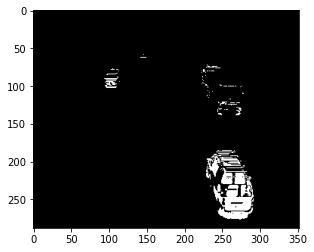

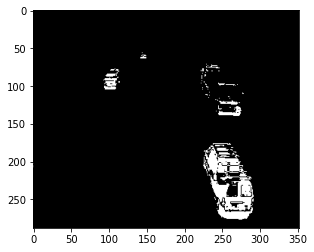

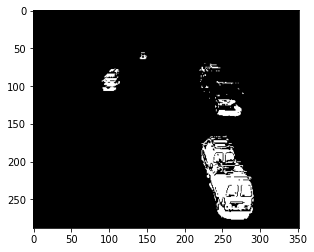

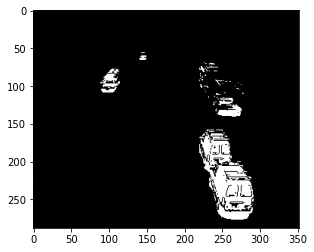

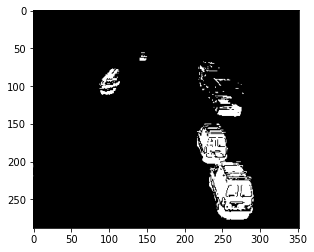

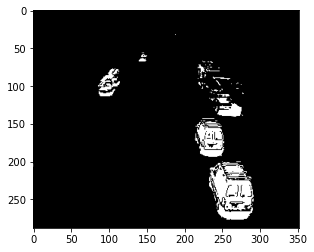

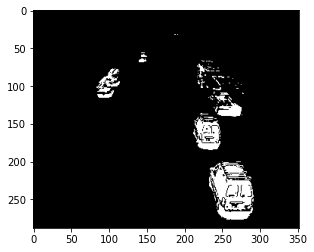

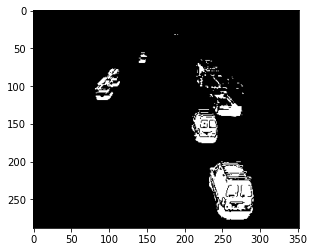

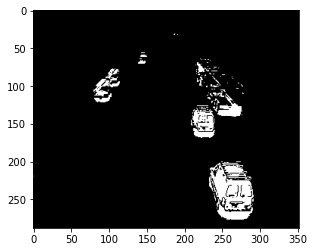

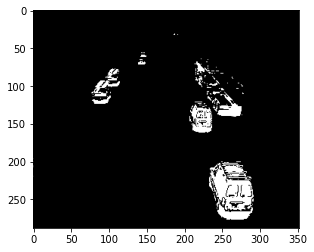

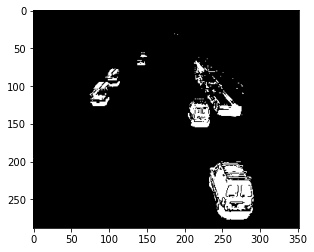

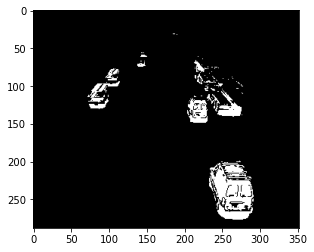

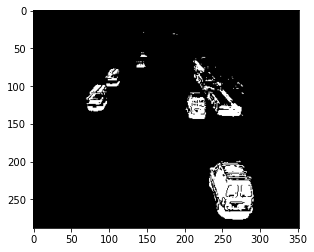

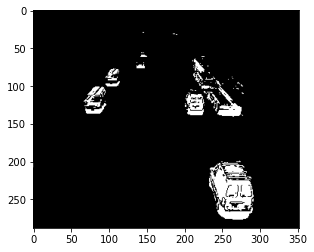

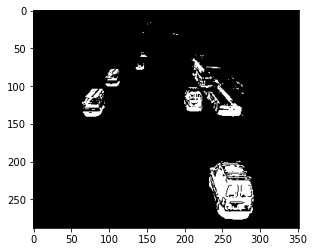

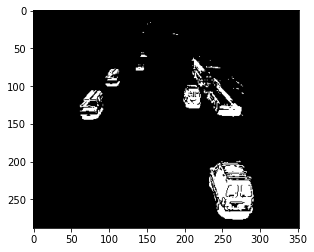

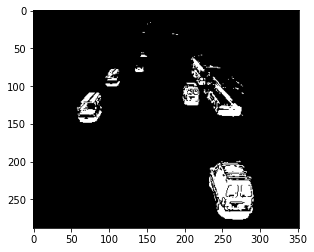

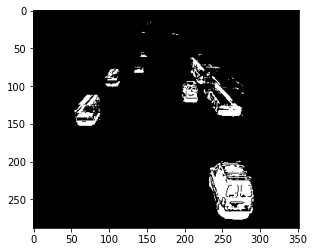

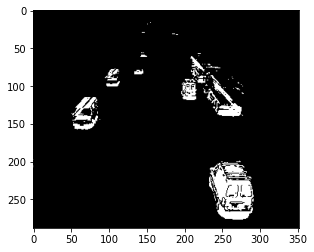

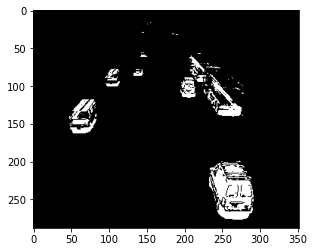

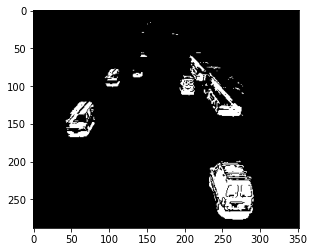

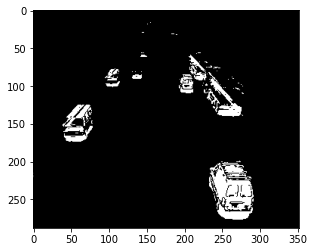

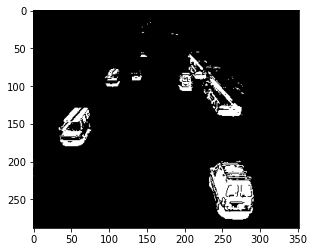

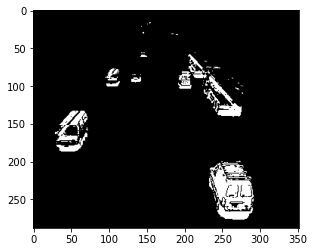

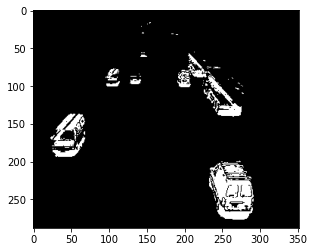

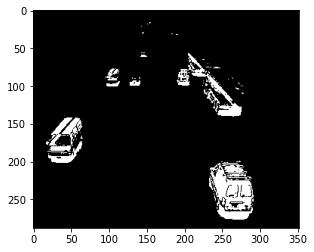

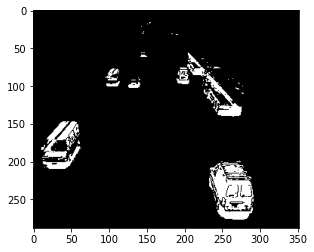

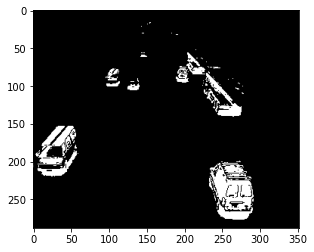

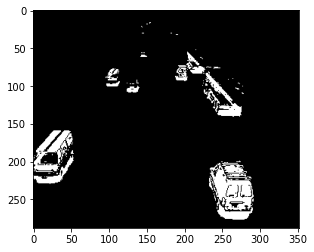

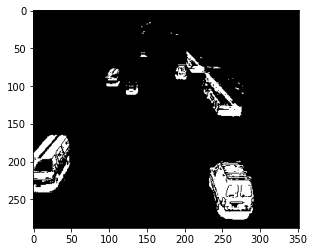

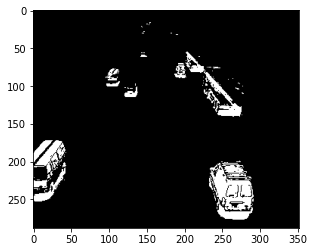

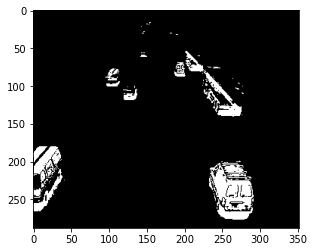

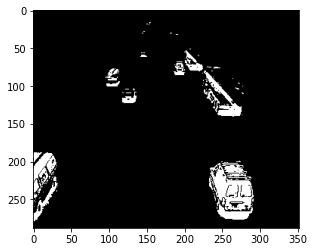

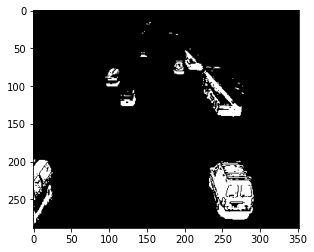

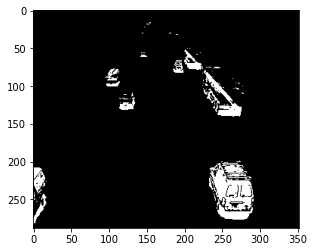

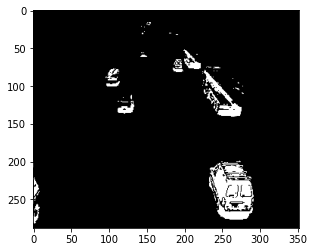

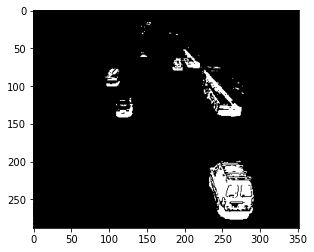

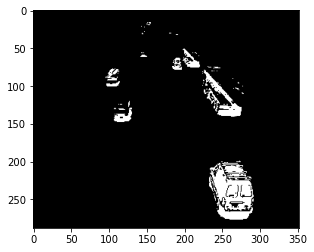

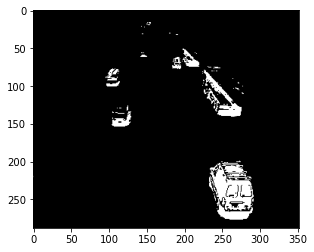

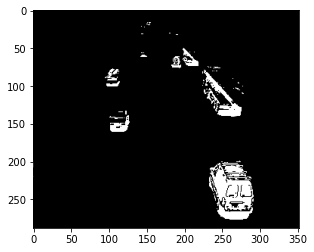

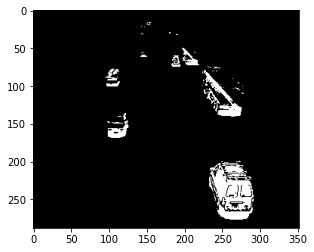

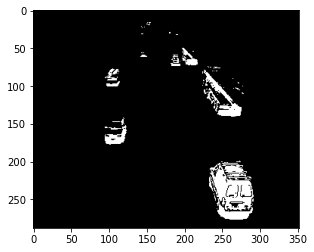

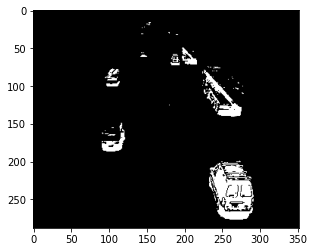

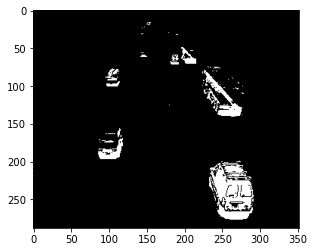

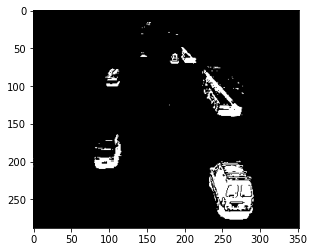

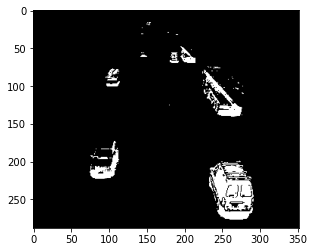

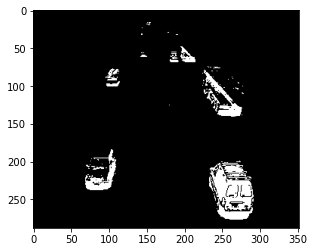

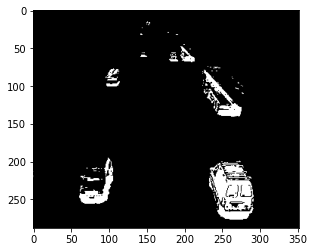

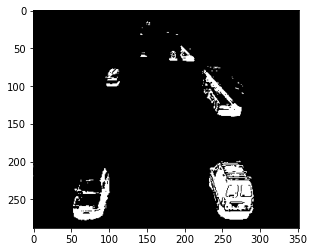

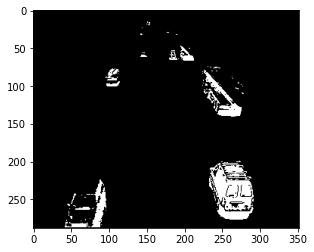

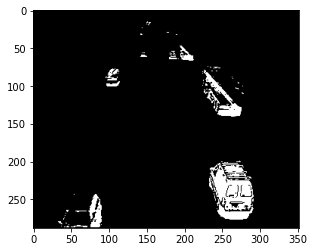

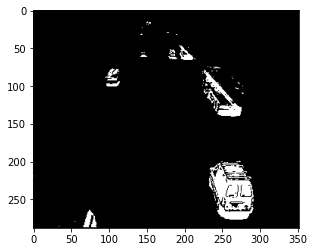

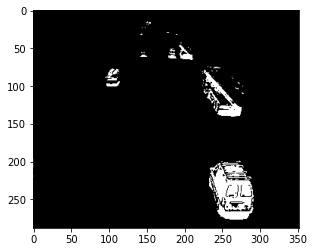

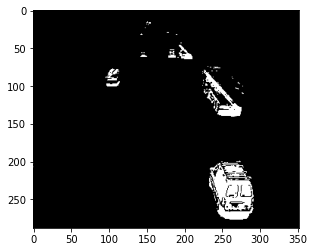

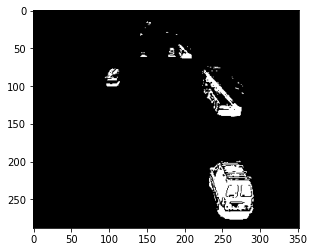

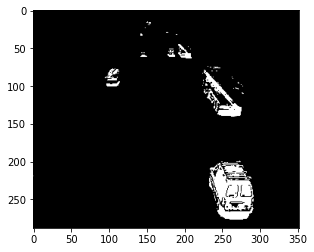

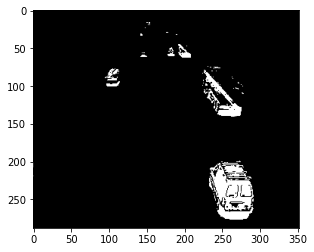

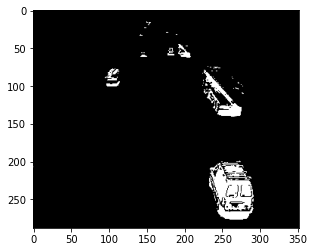

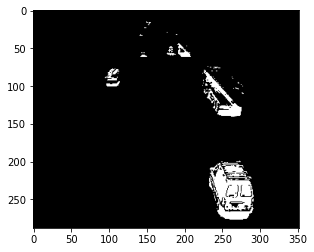

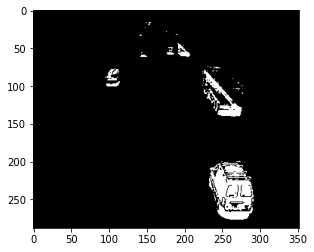

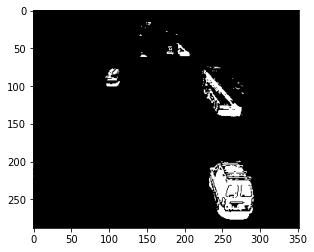

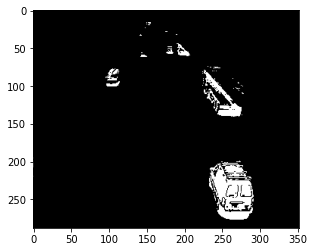

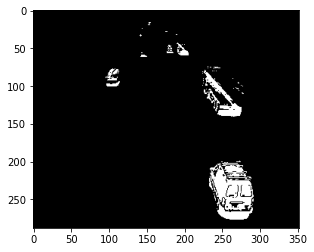

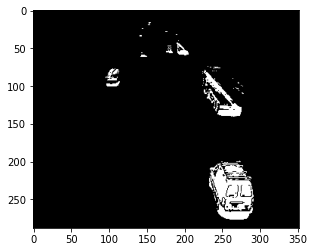

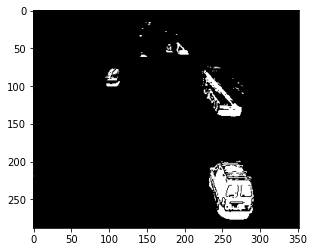

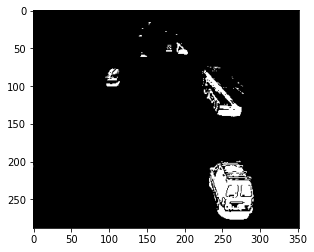

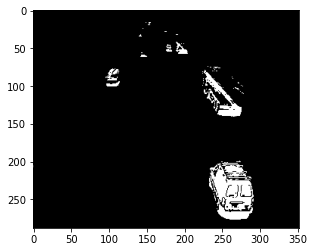

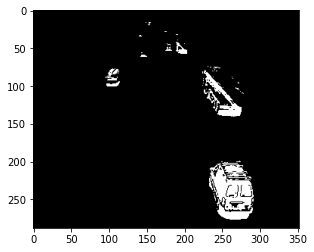

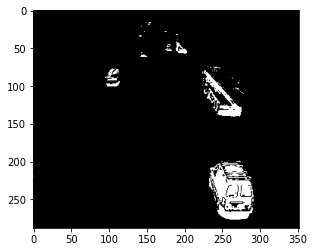

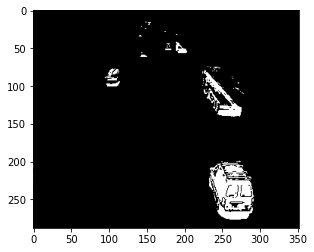

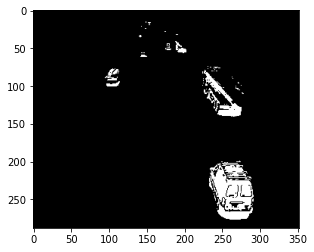

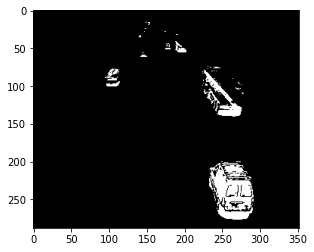

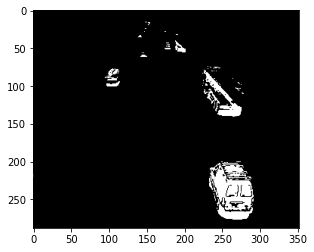

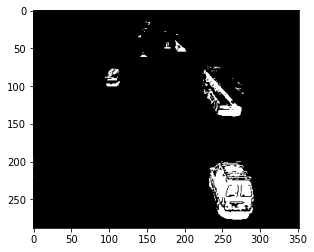

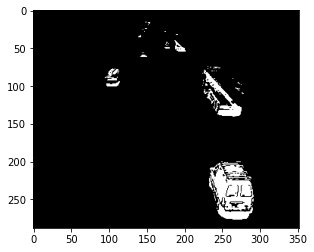

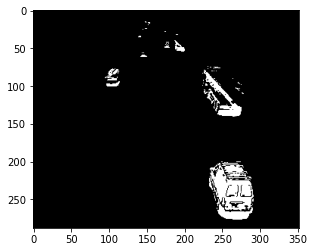

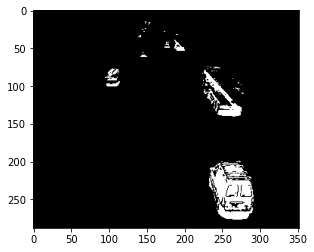

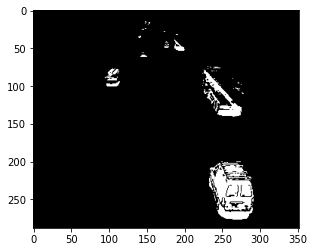

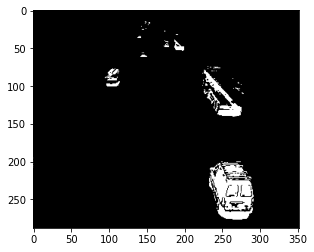

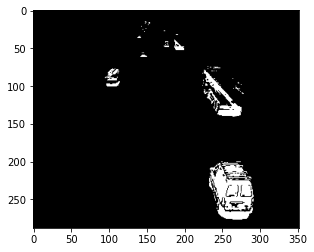

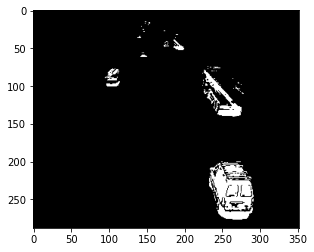

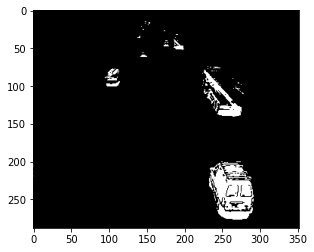

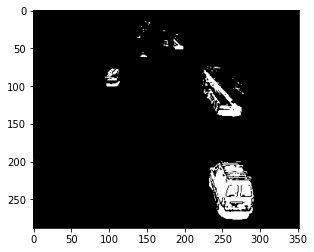

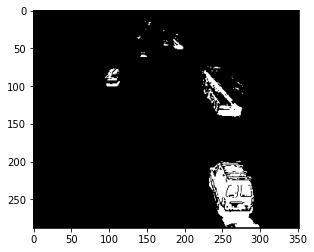

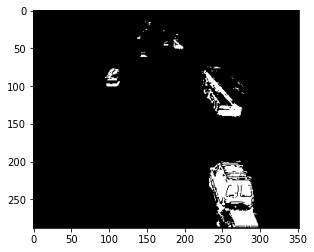

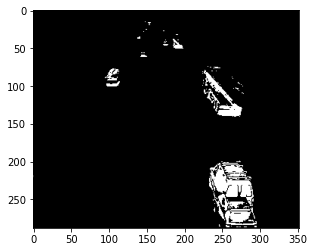

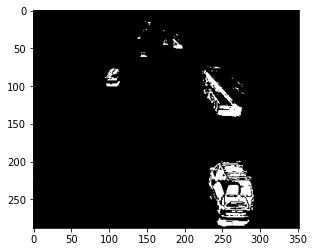

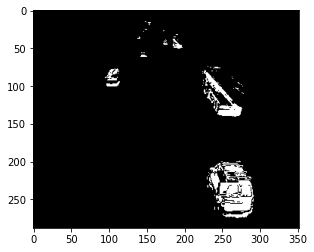

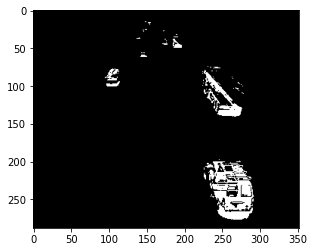

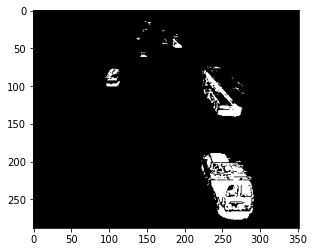

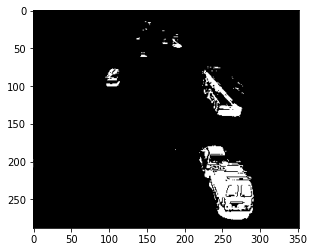

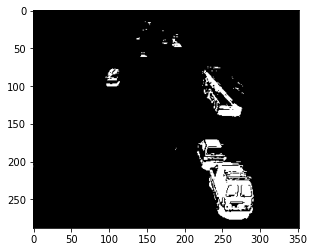

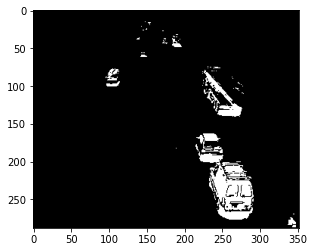

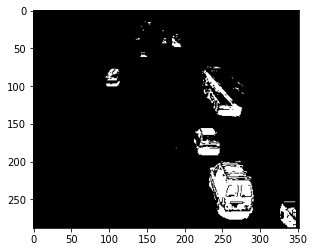

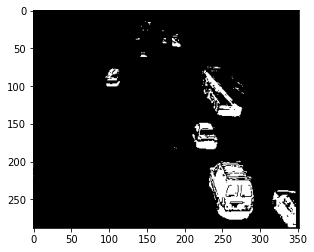

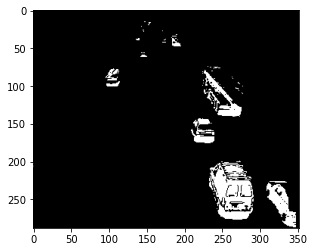

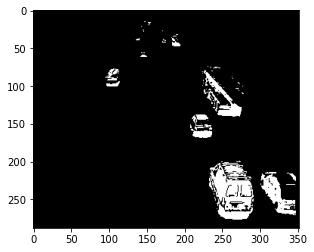

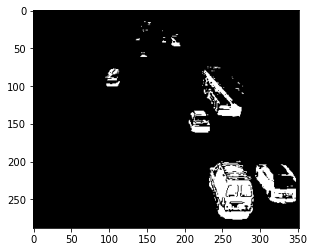

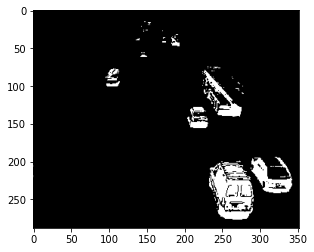

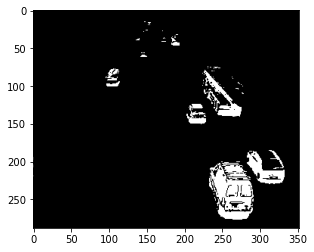

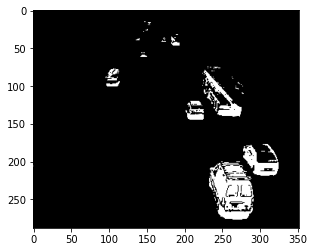

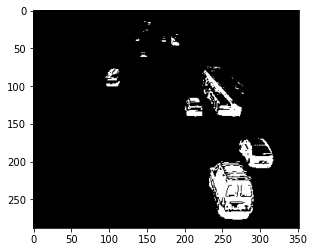

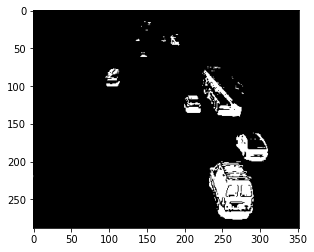

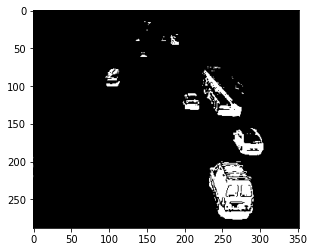

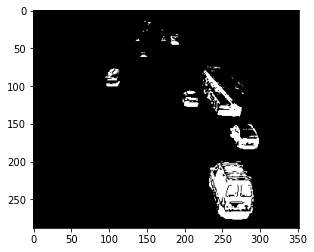

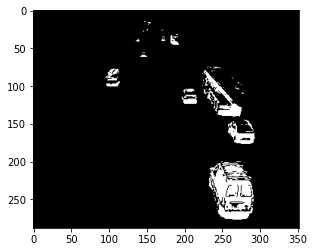

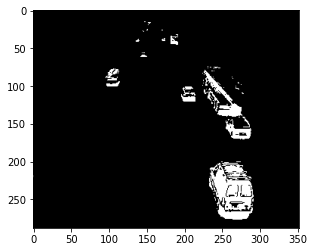

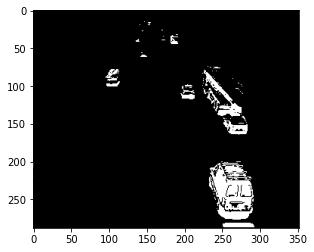

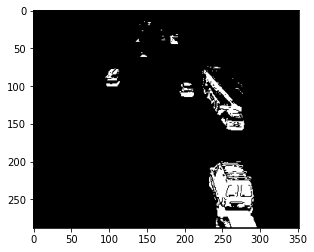

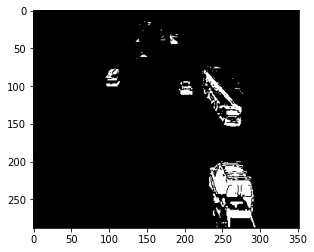

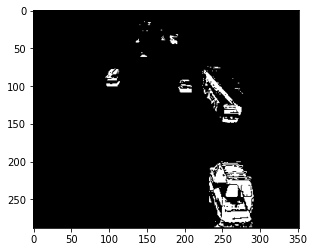

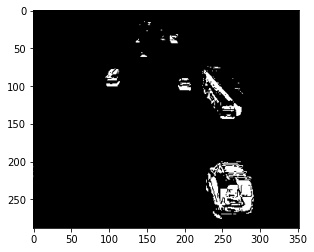

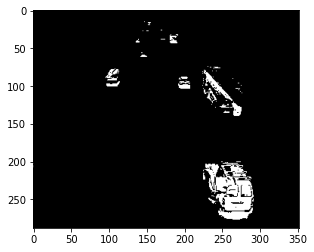

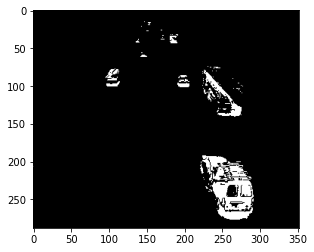

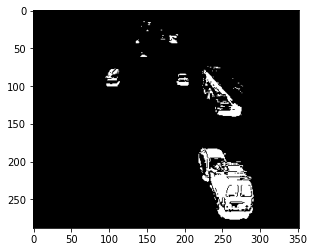

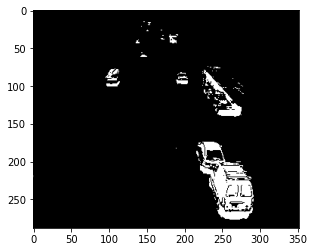

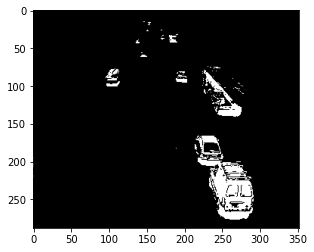

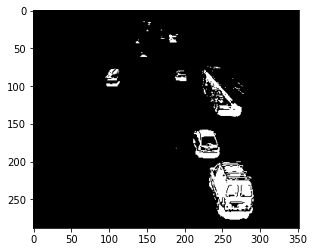

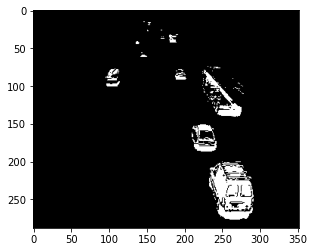

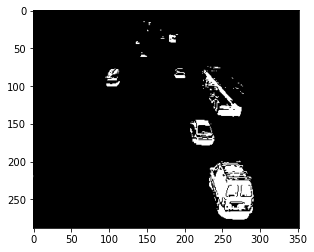

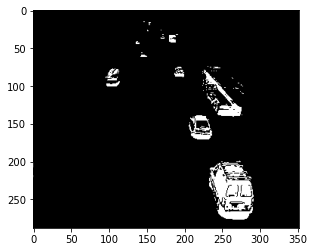

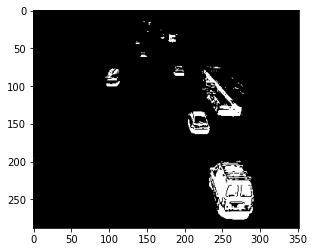

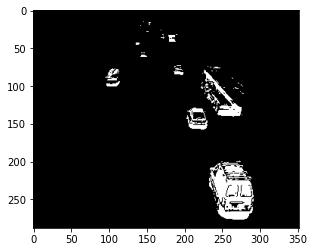

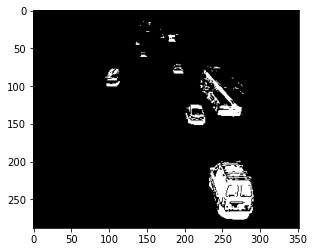

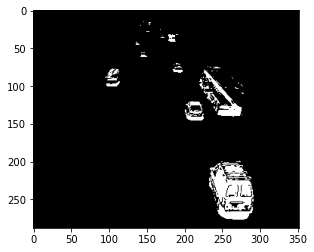

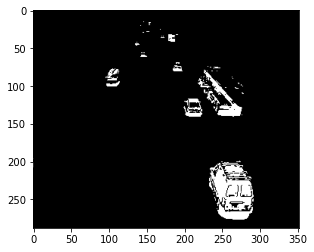

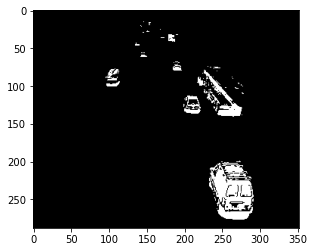

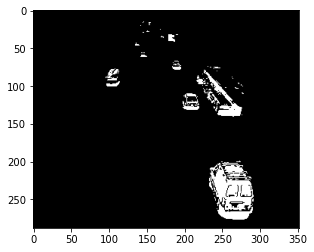

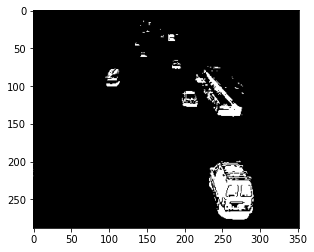

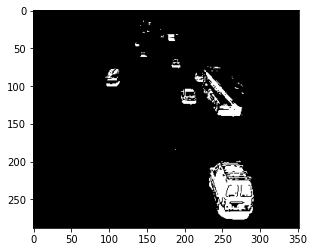

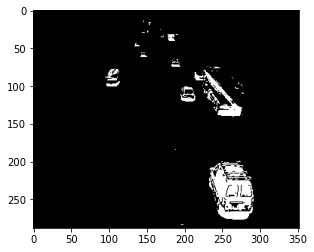

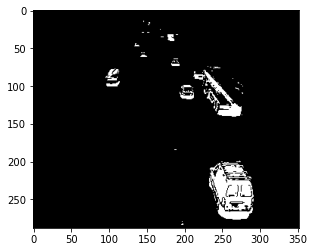

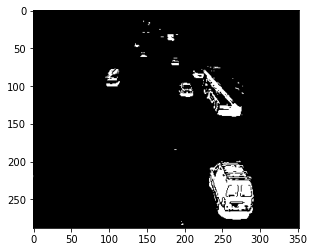

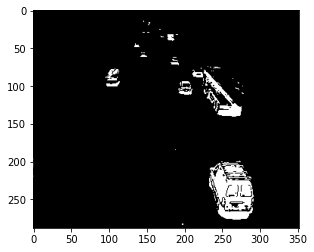

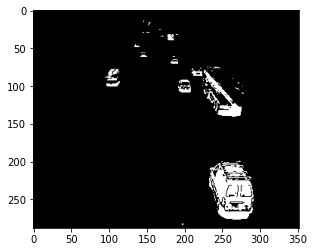

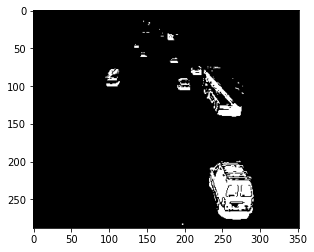

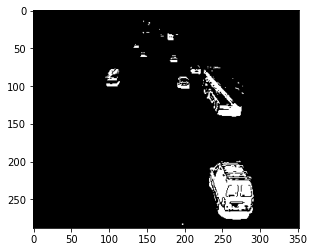

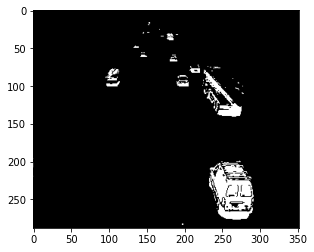

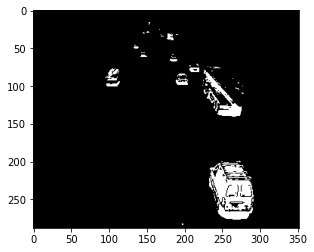

In [6]:
ref_frame = frames[0]
threshold = 50
for frame in frames[1:]:
    curent_motion = ICV_pixel_frame_differencing(ref_frame, frame, threshold, show_plot=True)


b) Repeat the exercise using the previous frame as reference frame (use frame It-1 as reference frame for frame It, for each t). Comment the results in the report.

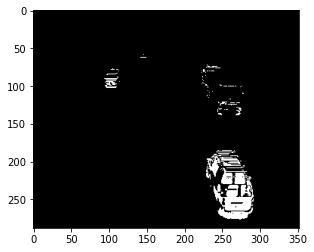

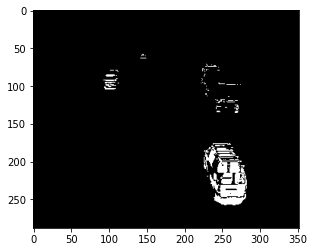

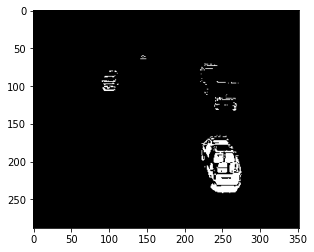

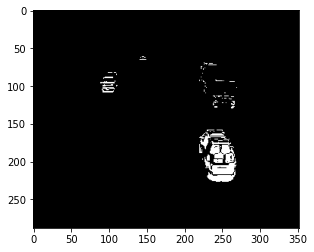

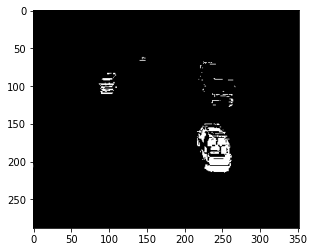

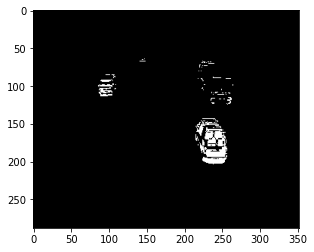

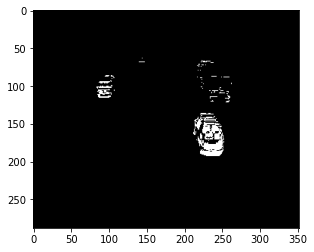

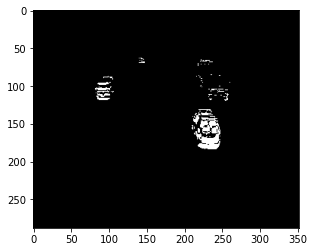

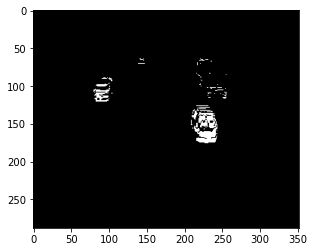

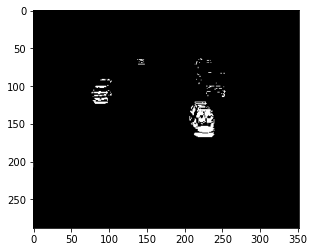

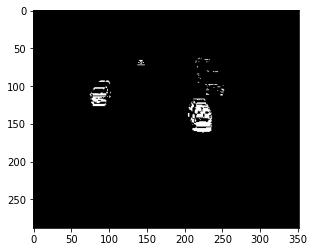

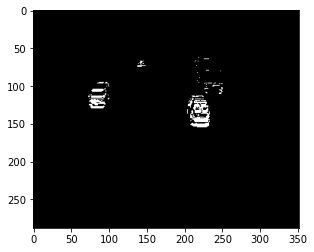

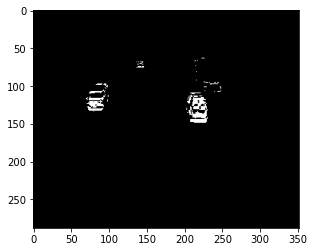

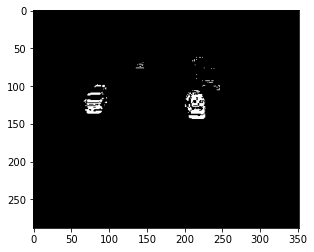

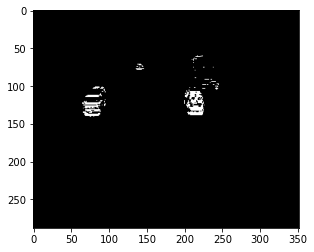

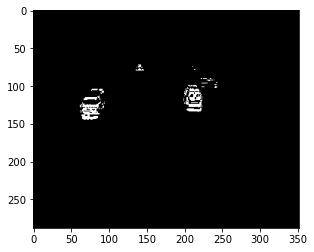

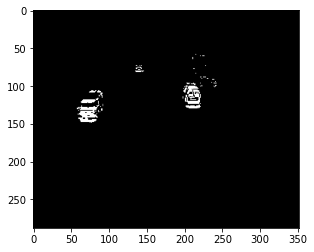

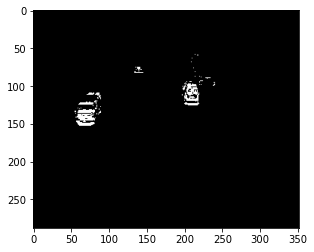

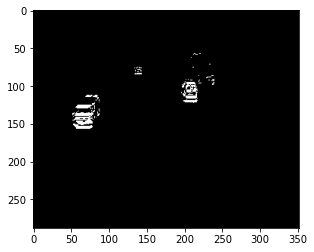

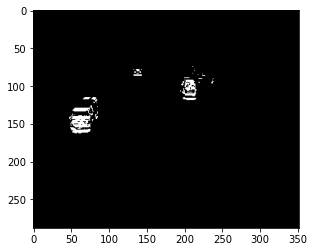

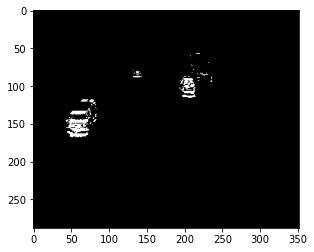

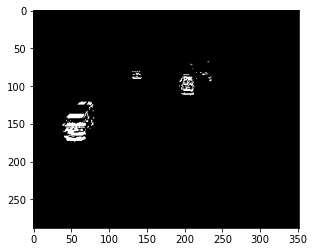

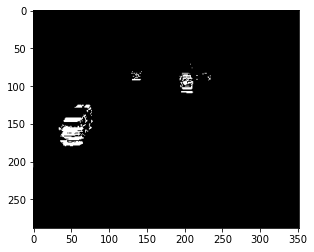

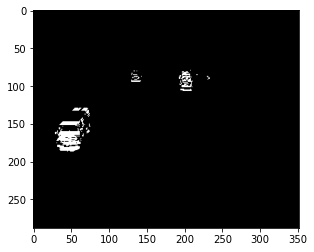

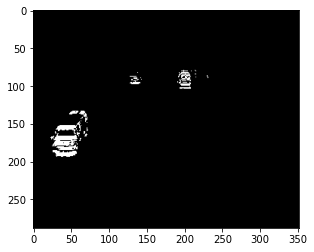

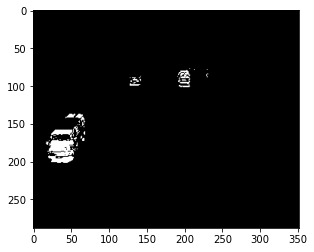

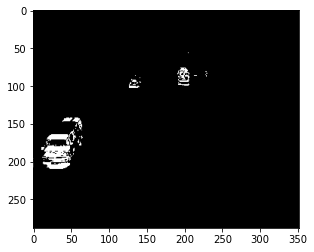

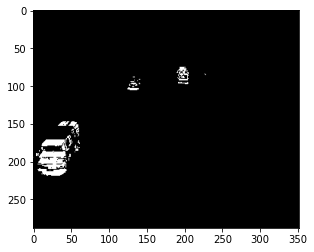

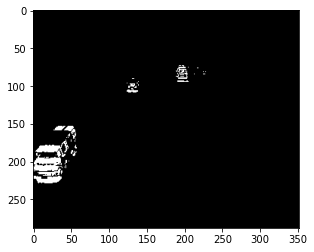

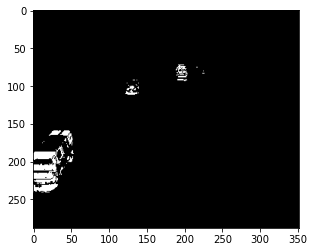

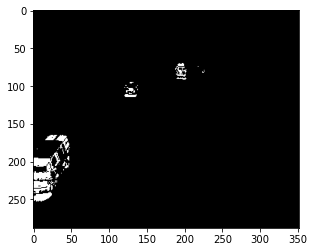

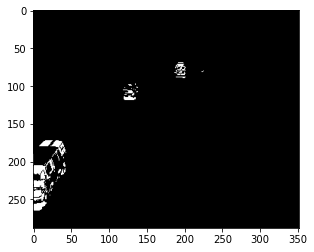

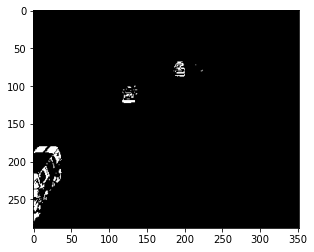

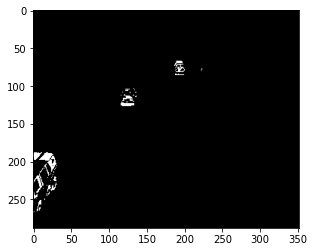

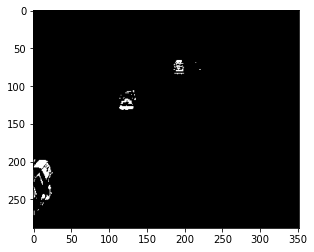

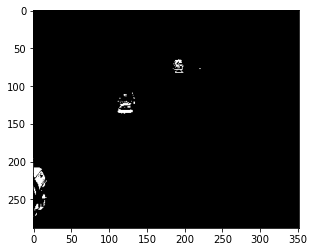

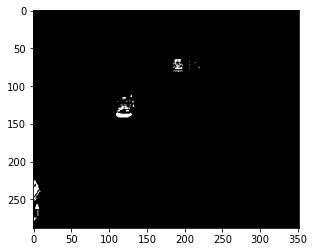

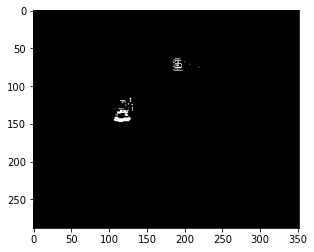

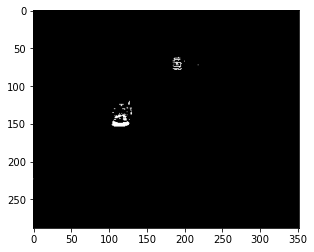

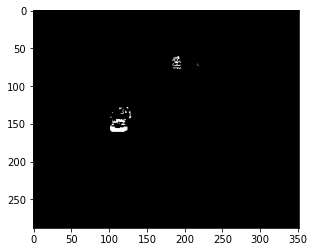

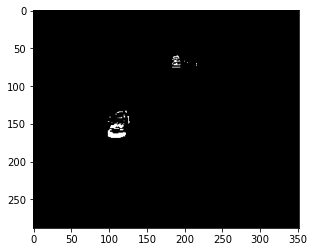

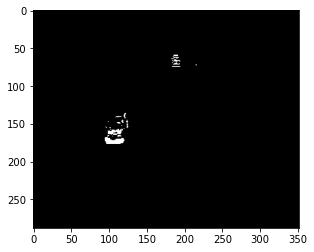

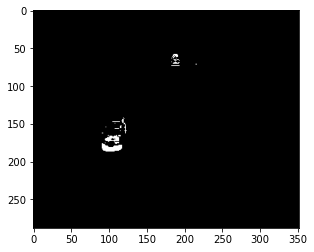

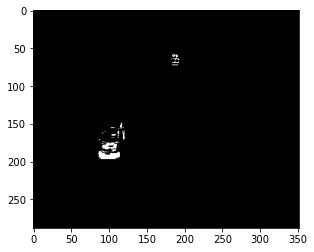

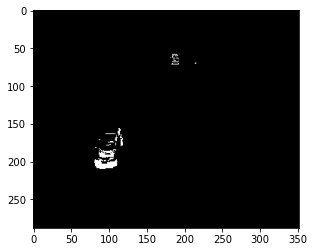

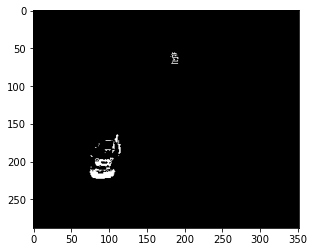

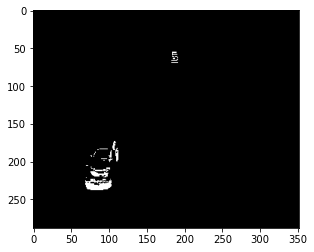

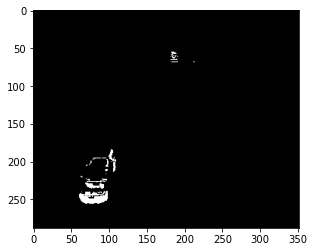

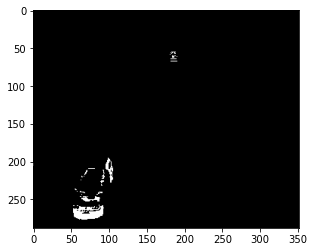

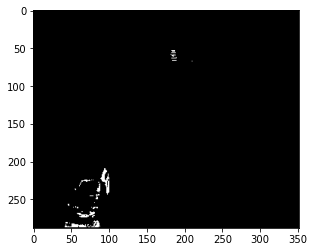

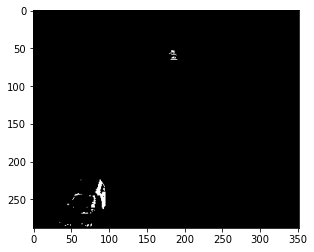

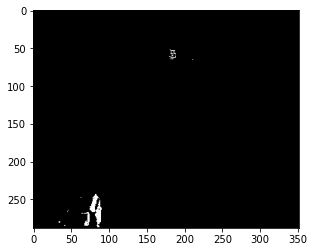

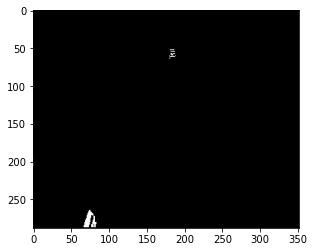

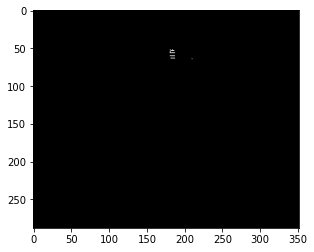

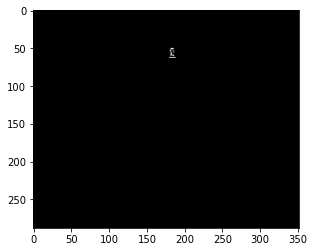

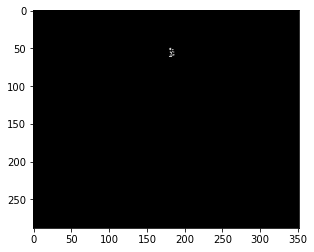

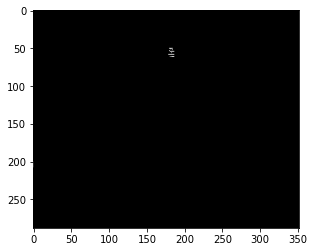

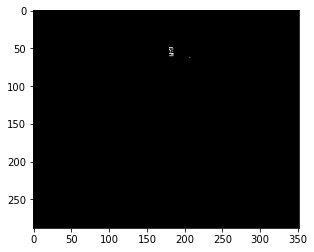

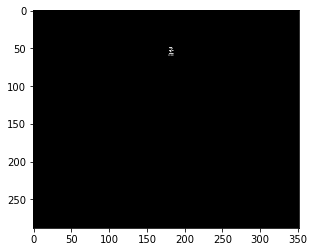

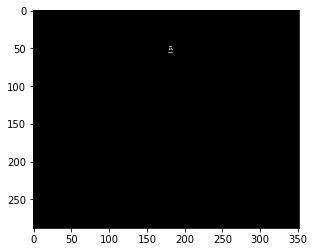

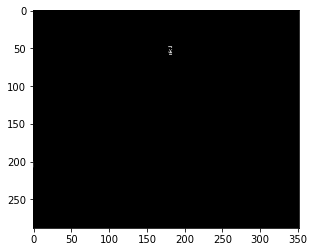

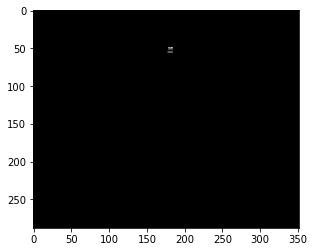

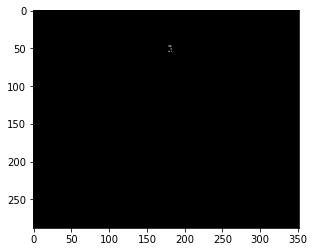

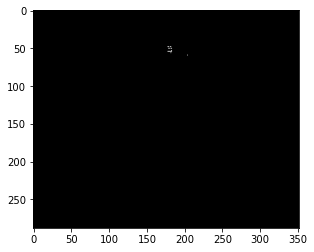

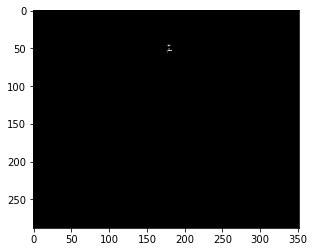

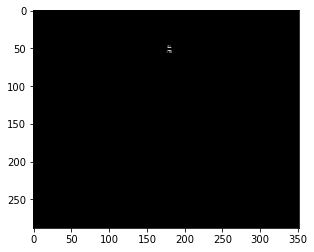

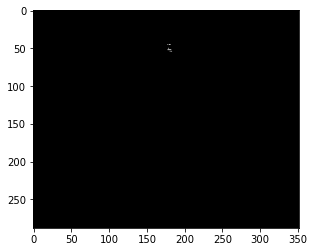

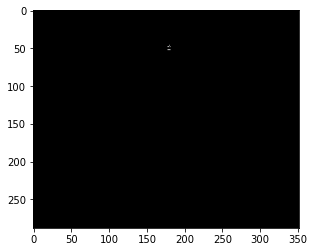

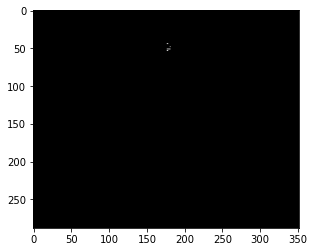

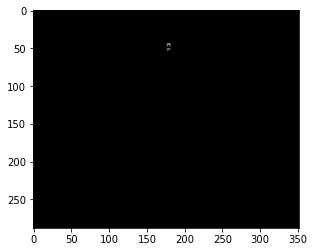

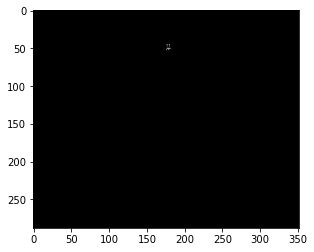

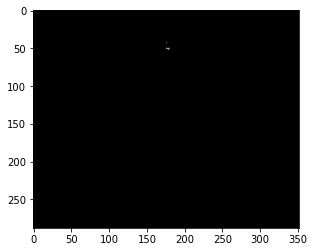

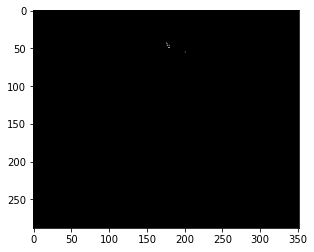

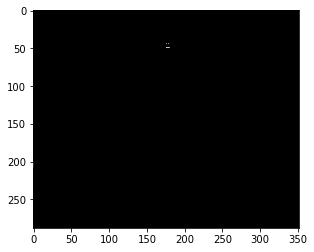

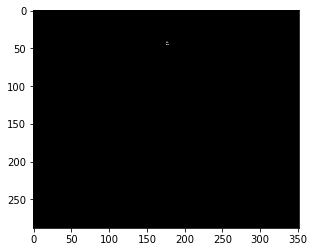

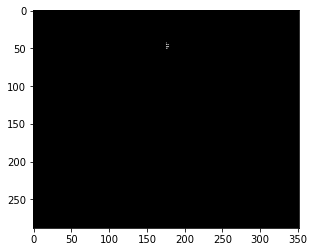

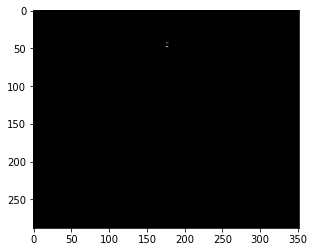

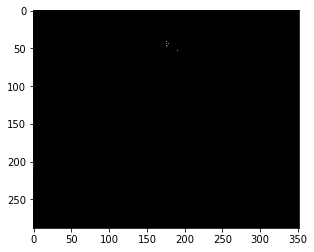

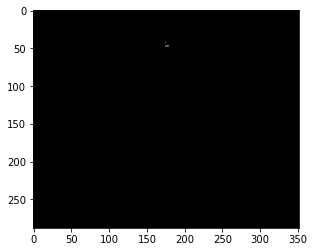

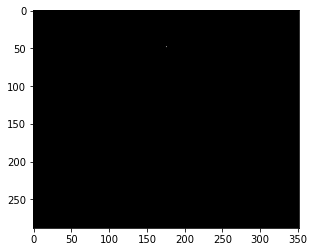

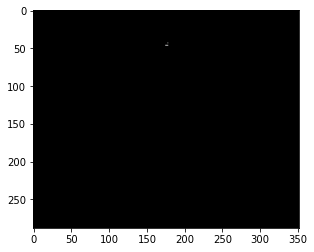

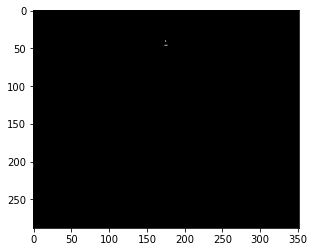

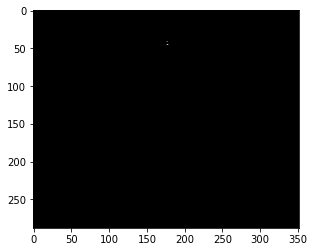

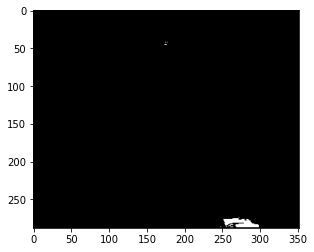

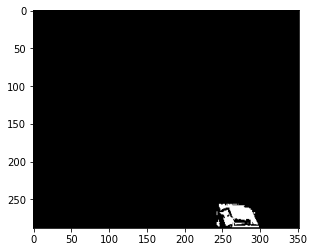

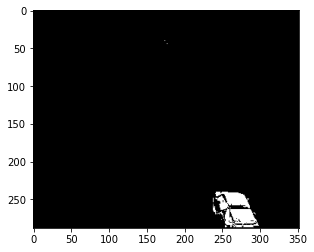

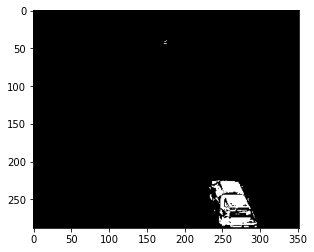

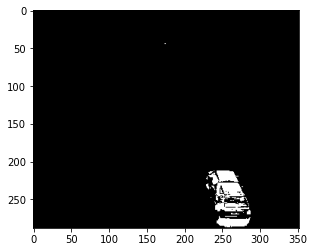

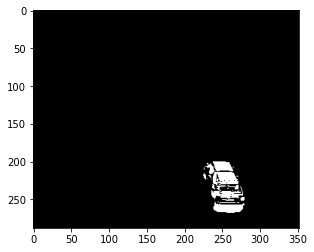

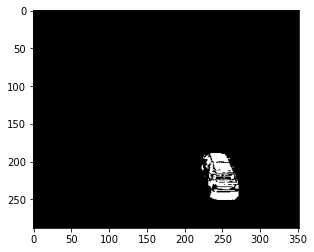

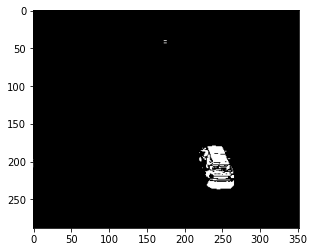

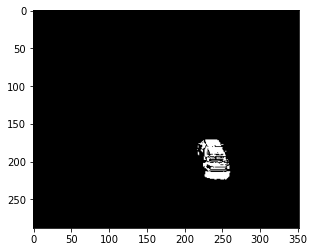

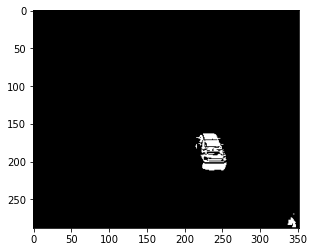

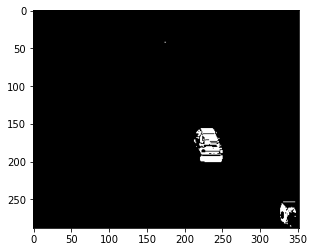

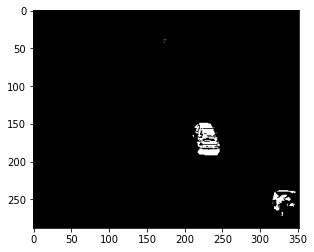

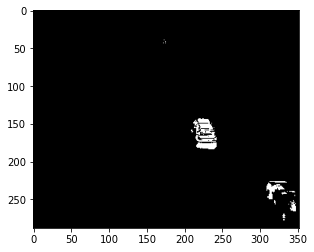

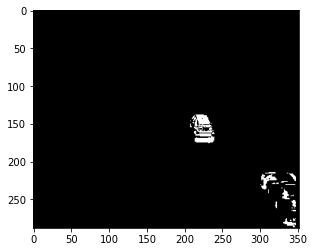

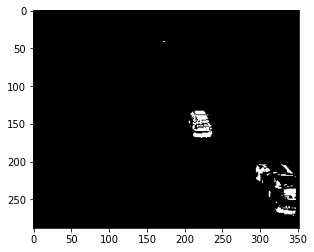

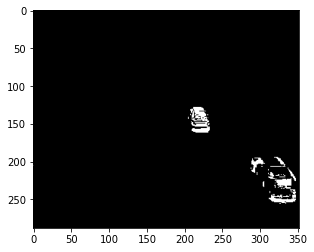

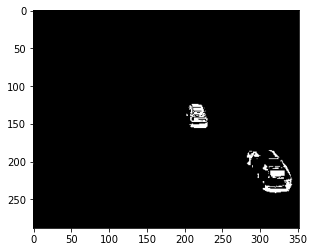

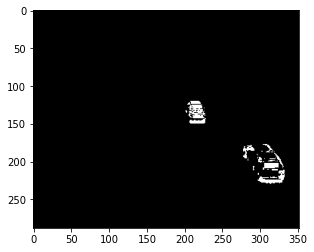

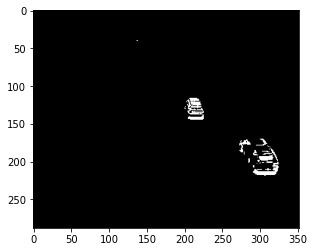

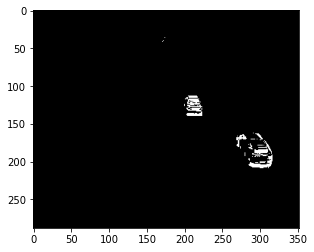

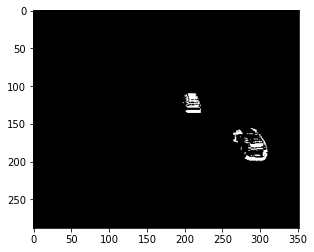

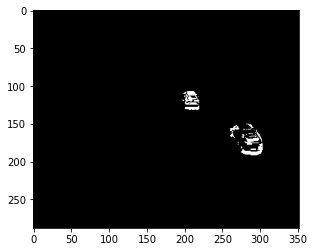

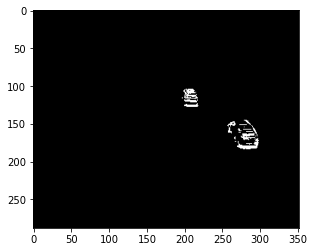

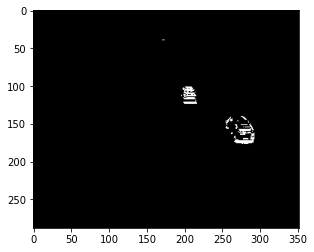

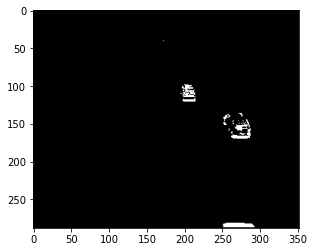

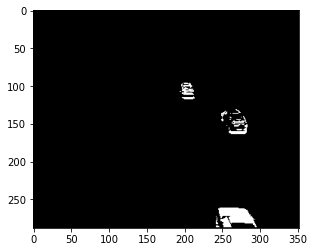

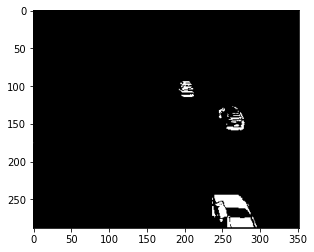

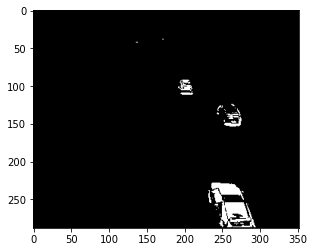

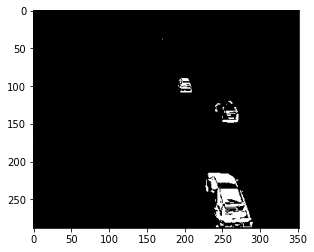

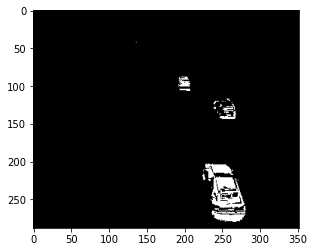

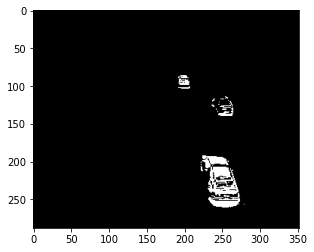

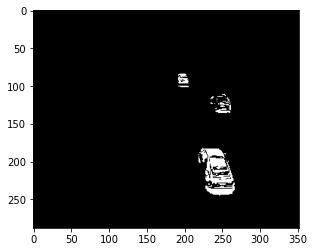

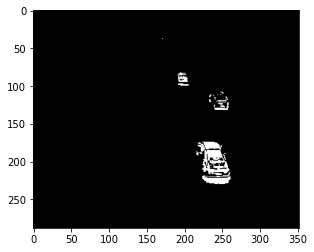

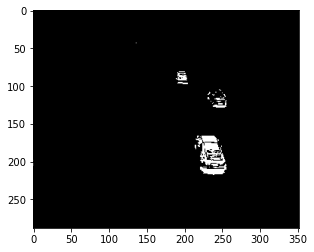

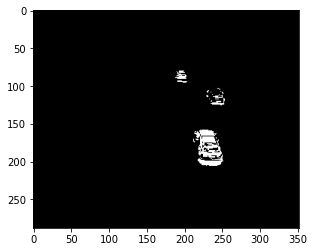

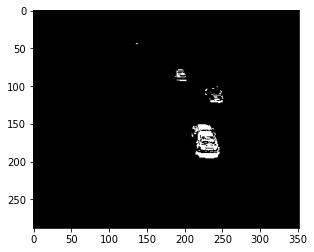

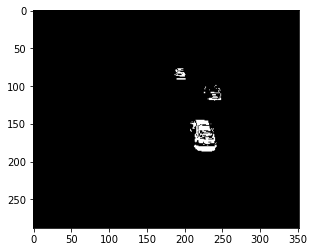

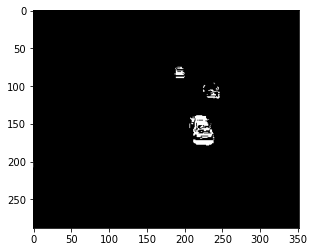

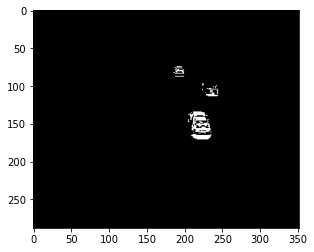

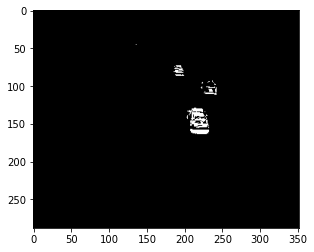

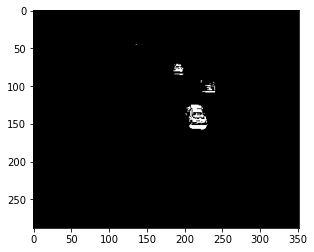

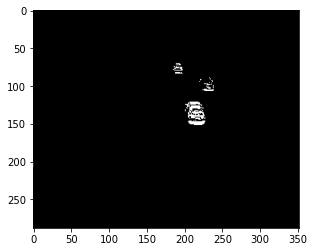

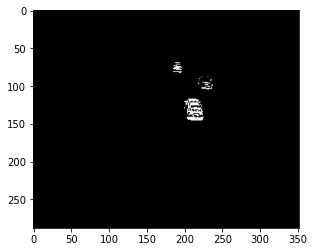

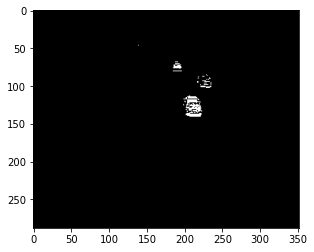

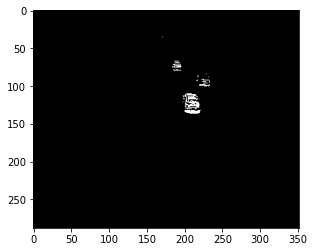

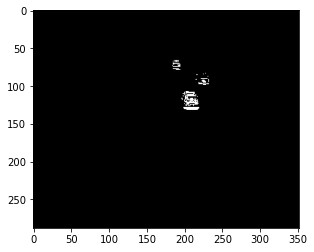

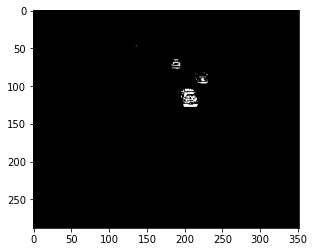

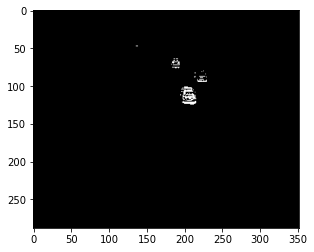

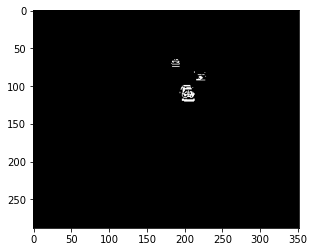

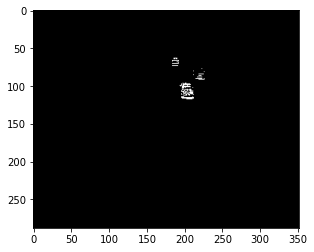

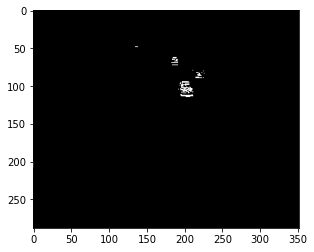

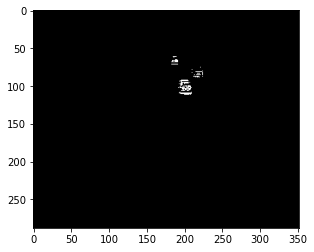

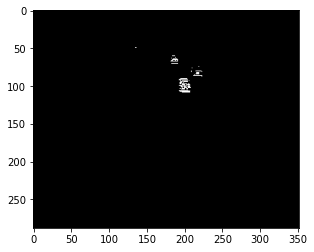

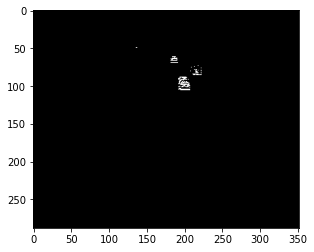

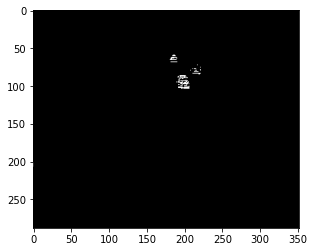

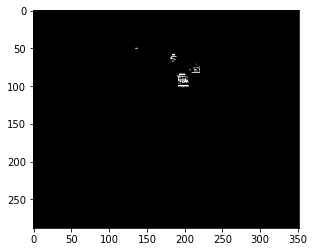

In [7]:
threshold = 50
for i in range(1,len(frames)):
    curent_motion = ICV_pixel_frame_differencing(frames[i-1], frames[i], threshold, show_plot = True)


c) Write a function that generates a reference frame (background) for the sequence using for example frame differencing and a weighted temporal averaging algorithm.

In [9]:
def ICV_generate_ref_frame(frames):
    frames = np.array(frames)
    background_frame = np.zeros((frames[0].shape[0],frames[0].shape[1]))
    
    
    for i in range(background_frame.shape[0]):
        for j in range(background_frame.shape[1]):
            sum_pix = 0
            for k in range(len(frames)):
                sum_pix += frames[k][i][j]  
            background_frame[i][j] = sum_pix // len(frames) 
        
    return background_frame

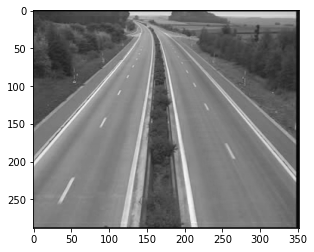

In [10]:
back = ICV_generate_ref_frame(frames)

plt.imshow(back,cmap = 'gray')


d) Write a function that counts the number of moving objects in each frame of a sequence. Generate a bar plot that visualizes the number of objects for each frame of the whole sequence. Discuss in the report the implemented solution, including advantages and disadvantages.

In [11]:
def ICV_image_dilation(image, kernel):
    
    #calulating kernel multiplication factor 
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    dilated_image = np.zeros((image.shape[0],image.shape[1]))
    
    for i in range(0+(kernel_h//2), image.shape[0]-(kernel_h//2)): #iterating image height
        for j in range(0+(kernel_w//2), image.shape[1]-(kernel_w//2)):
            #if dilated_image[i][j]==1.0:
            dilate_part = image[i-(kernel_h//2):i+(kernel_w//2)+1,j-(kernel_h//2):j+(kernel_w//2)+1]
            
            is_dilate = False
            for k in range(kernel_h):
                for m in range(kernel_w):
                    if k==m:
                        pass
                    else:
                        if dilate_part[k][m]==kernel[k][m]:
                            is_dilate = True
                            break
                                
            if is_dilate == True:
                dilated_image[i][j]=1
            else:
                dilated_image[i][j]=0
    
    return dilated_image
                                
                        


In [12]:
def ICV_image_eroison(image):
    #calulating kernel multiplication factor 
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    eroded_image = np.zeros((image.shape[0],image.shape[1]))
    
    for i in range(0+(kernel_h//2), image.shape[0]-(kernel_h//2)): #iterating image height
        for j in range(0+(kernel_w//2), image.shape[1]-(kernel_w//2)):
            erode_part = image[i-(kernel_h//2):i+(kernel_w//2)+1,j-(kernel_h//2):j+(kernel_w//2)+1]
            
            is_erode = True
            for k in range(kernel_h):
                for m in range(kernel_w):
                    if k==m:
                        pass
                    else:
                        if erode_part[k][m]!=kernel[k][m]:
                            is_erode = False
                            break
            if is_erode:
                eroded_image[i][j]=1
            else:
                eroded_image[i][j]=0
    return eroded_image

In [15]:
def ICV_flood_fill(frame_erosion,x,y):
    
    matrix_flooded = frame_erosion
    
    active_frontier = {(x,y)}
    
    while active_frontier:
        next_frontier = set()
        for node in active_frontier:
            
            # check above
            if node[0]>0:
                above_node = (node[0]-1, node[1])
                if frame_erosion[above_node] == 1:
                    next_frontier |= {above_node}
            
            # check below
            if node[0]<frame_erosion.shape[0]-1:
                below_node = (node[0]+1, node[1])
                if frame_erosion[below_node] == 1:
                    next_frontier |= {below_node}
            
            # check left
            if node[1]>0:
                left_node = (node[0], node[1]-1)
                if frame_erosion[left_node] == 1:
                    next_frontier |= {left_node}
            
            # check right
            if node[1]<frame_erosion.shape[1]-1:
                right_node = (node[0],node[1]+1)
                if frame_erosion[right_node] == 1:
                    next_frontier |= {right_node}
            
            
            for nodes in next_frontier:
                matrix_flooded[node] = 0.
            active_frontier = next_frontier
    
    return matrix_flooded


In [ ]:
def ICV_count_object(frames, threshold=50):
    
    ref_frame = ICV_generate_ref_frame(frames)
    
    object_count = []
    
    kernel = np.ones((15,15), np.uint8)
    
    for frame in frames:
        frame_threshold = ICV_pixel_frame_differencing(ref_frame, frame, threshold, show_plot=False)
        
        #image_dilation
        frame_dilate = ICV_image_dilation(frame_threshold, kernel)
        
        #image erosion
        frame_erosion = ICV_image_dilation(frame_dilate, kernel)
        
        #Count object using flood fill
        count = 0
        filled_pixels = []
        for i in range(frame_erosion.shape[0]):
            for j in range(frame_erosion.shape[1]):
                if int(frame_erosion[i][j]) == 1 :
                    frame_erosion = ICV_flood_fill(frame_erosion,i,j)
                    count +=1
        object_count.append(count)
    
    plt.plot(range(len(frames)),object_count)
    plt.show()
                    
        
        
threshold=175
ICV_count_object(frames,threshold)
    
    